# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based machine learning models in order to find the one that predicts STM transit delays with the best accuracy. The featured models are XGBoost, LightGBM and CatBoost, because they are more suitable for large datasets with mixed data and high cardinality.

## Data Description

`exp_trip_duration`: Expected duration of a trip, in seconds.<br>
`route_direction_North`, `route_direction_South`, `route_direction_West`: Route direction in degrees.<br>
`route_type_Night`, `route_type_HighFrequency` : One-Hot features for types of bus lines<br>
`frequency_frequent`, `frequency_normal`, `frequency_rare`, `frequency_very_frequent`, `frequency_very_rare`: One-Hot features for number of arrivals per hour.<br>
`stop_location_group`: Stop cluster based on coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`trip_phase_middle`, `trip_phase_end`: One-Hot feature for trip progress.<br>
`exp_delay_prev_stop`: Expected duration between the previous and current stop, in seconds.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`sch_rel_Scheduled`: One-Hot feature for schedule relationship.<br>
`time_of_day_evening`, `time_of_day_morning`, `time_of_day_night`: One-Hot features for time of day.<br>
`is_peak_hour`: Boolean value indicating if the sheduled arrival time is at peak hour.<br>
`temperature_2m`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity_2m`: Relative humidity at 2 meters above ground, in percentage.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed_10m`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction_10m`: Wind direction at 10 meters above ground.<br>

## Imports

In [1]:
from catboost import CatBoostRegressor
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import shap
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import xgboost as xgb

In [3]:
# Load data
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (1250000, 30)


## Split the data

In [4]:
# Separate features from target variable
X = df.drop('delay', axis=1)
y = df['delay']

The 3 models can run multiple iterations (epochs) with a training and validation set. Therefore, a hold-out set will be kept for the final model.

In [5]:
# Train-validation-test split (60-20-20)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

del X_temp
del y_temp

**Scaling**

Since only tree-based models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## Fit Base Models

All models allow to setup a number of rounds and early stopping. To start, all models will run 100 rounds with an early stopping of 3.

In [6]:
# Create dataframe to track metrics
reg_metrics_df = pd.DataFrame(columns=['model', 'MAE', 'RMSE', 'R²'])

In [7]:
def add_reg_metrics(reg_metrics_df:pd.DataFrame, y_pred:pd.Series, y_true:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_true, y_pred)
	rmse = root_mean_squared_error(y_true, y_pred)
	r2 = r2_score(y_true, y_pred)

	reg_metrics_df.loc[len(reg_metrics_df)] = [model_name, mae, rmse, r2]
	return reg_metrics_df

### XGBoost

In [8]:
# Create regression matrices
xg_train_data = xgb.DMatrix(X_train, y_train, enable_categorical=False)
xg_val_data = xgb.DMatrix(X_val, y_val, enable_categorical=False)
xg_test_data = xgb.DMatrix(X_test, y_test, enable_categorical=False)
xg_eval_set = [(xg_train_data, 'train'), (xg_val_data, 'validation')]
xg_test_set = [(xg_train_data, 'train'), (xg_test_data, 'test')]

In [9]:
# Train model
xg_reg_base = xgb.train(
  params= {'objective': 'reg:squarederror', 'tree_method': 'hist'},
  dtrain=xg_train_data,
  num_boost_round=100,
  evals=xg_eval_set,
  verbose_eval=10,
  early_stopping_rounds=3
)

[0]	train-rmse:158.52739	validation-rmse:158.64413
[10]	train-rmse:151.35025	validation-rmse:151.96813
[20]	train-rmse:149.23615	validation-rmse:150.18411
[30]	train-rmse:147.44817	validation-rmse:148.63004
[40]	train-rmse:145.81188	validation-rmse:147.29864
[50]	train-rmse:144.75192	validation-rmse:146.37798
[60]	train-rmse:143.32785	validation-rmse:145.29822
[70]	train-rmse:142.43365	validation-rmse:144.65399
[80]	train-rmse:141.65022	validation-rmse:144.03462
[90]	train-rmse:140.87079	validation-rmse:143.46006
[99]	train-rmse:140.52111	validation-rmse:143.28277


In [10]:
# Evaluate model
y_pred = xg_reg_base.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,73.904972,143.282766,0.221865


**MAE**<br>
On average, the predictions are off by 74 seconds, which is not very good.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 22% of the variance, which is not good but understandable because of how random transit delays can be (bad weather, vehicle breakdown, accidents, etc.)

### LightGBM

In [11]:
# Create regression matrices
lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data)
lgb_test_data = lgb.Dataset(X_test, label=y_test, reference=lgb_train_data)

In [12]:
# Train model
lgb_reg_base = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': -1
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=3)]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039538 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 817
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 29
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 54.339703
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 149.35


In [13]:
# Evaluate model
y_pred = lgb_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,73.904972,143.282766,0.221865
1,lgb_reg_base,76.864954,149.349684,0.154574


Overall, the LightGBM model performs worse than XGBoost.

### CatBoost

In [14]:
# Fit model
cat_reg_base = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=10,
    random_seed=42,
    verbose=10
)

cat_reg_base.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=3)

0:	learn: 161.7233695	test: 161.7288992	best: 161.7288992 (0)	total: 209ms	remaining: 20.7s
10:	learn: 157.3511353	test: 157.4027588	best: 157.4027588 (10)	total: 1.65s	remaining: 13.4s
20:	learn: 154.9858448	test: 155.0852439	best: 155.0852439 (20)	total: 2.92s	remaining: 11s
30:	learn: 153.7470187	test: 153.9068790	best: 153.9068790 (30)	total: 4.48s	remaining: 9.96s
40:	learn: 152.8124766	test: 152.9680437	best: 152.9680437 (40)	total: 5.69s	remaining: 8.19s
50:	learn: 152.1677868	test: 152.3654184	best: 152.3654184 (50)	total: 6.9s	remaining: 6.63s
60:	learn: 151.3132711	test: 151.6271327	best: 151.6271327 (60)	total: 8.36s	remaining: 5.35s
70:	learn: 150.7792843	test: 151.1288989	best: 151.1288989 (70)	total: 9.67s	remaining: 3.95s
80:	learn: 150.3331417	test: 150.7223869	best: 150.7223869 (80)	total: 11s	remaining: 2.57s
90:	learn: 149.7484310	test: 150.2975918	best: 150.2975918 (90)	total: 12.5s	remaining: 1.24s
99:	learn: 149.2134500	test: 149.8558599	best: 149.8558599 (99)	tot

In [15]:
# Evaluate model
y_pred = cat_reg_base.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_base')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,73.904972,143.282766,0.221865
1,lgb_reg_base,76.864954,149.349684,0.154574
2,cat_reg_base,76.683782,149.855860,0.148834


CatBoost performs almost like LightGBM. Without tuning, XGBoost seems to capture a bit more of the underlying patterns than the two other models.

## Hyperparameter Tuning

### XGBoost

In [16]:
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500, 600],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=600, subsample=0.8; total time= 1.4min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time= 1.5min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.6; total time= 1.5min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=0.8; total time= 1.9min
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=400, subsample=0.8; total time= 1.9min
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=600, subsample=1.0; total time= 2.5min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8; total time= 1.1min
[CV] END colsample

RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [17]:
# Best model
xg_best_model = random_search.best_estimator_
xg_best_params = random_search.best_params_

In [18]:
# Train best model with more boost rounds
xg_reg_tuned = xgb.train(
  params= {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'max_depth': xg_best_params['max_depth'],
    'learning_rate': xg_best_params['learning_rate'],
    'subsample': xg_best_params['subsample'],
    'colsample_bytree': xg_best_params['colsample_bytree'],
  },
  dtrain=xg_train_data,
  num_boost_round=10000,
  evals=xg_eval_set,
  verbose_eval=50,
  early_stopping_rounds=50
)

[0]	train-rmse:164.21644	validation-rmse:163.04327
[50]	train-rmse:151.22019	validation-rmse:151.44462
[100]	train-rmse:146.59012	validation-rmse:147.37237
[150]	train-rmse:144.12108	validation-rmse:145.54565
[200]	train-rmse:142.27527	validation-rmse:144.35063
[250]	train-rmse:140.31646	validation-rmse:142.98834
[300]	train-rmse:138.99454	validation-rmse:142.34960
[350]	train-rmse:137.78843	validation-rmse:141.68590
[400]	train-rmse:136.83340	validation-rmse:141.31718
[450]	train-rmse:135.77544	validation-rmse:140.80033
[500]	train-rmse:135.06032	validation-rmse:140.67086
[550]	train-rmse:134.26411	validation-rmse:140.35345
[600]	train-rmse:133.51313	validation-rmse:140.13732
[650]	train-rmse:132.77692	validation-rmse:139.90499
[700]	train-rmse:132.05796	validation-rmse:139.62520
[750]	train-rmse:131.40343	validation-rmse:139.43315
[800]	train-rmse:130.82296	validation-rmse:139.26148
[850]	train-rmse:130.35177	validation-rmse:139.26772


In [19]:
# Evaluate model
y_pred = xg_reg_tuned.predict(xg_val_data)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'xg_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,75.214775,145.386440,0.220398
1,lgb_reg_base,78.092183,151.552359,0.152869
2,cat_reg_base,78.068989,152.208080,0.145523
3,xg_reg_tuned,71.949440,139.269234,0.284622


There's a significant improvement from the base XGBoost model and it's the best performing model so far.

### LightGBM

In [20]:
param_dist = {
  'n_estimators': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [5, 10, 15],
  'num_leaves': [20, 31, 40],
  'min_child_samples': [10, 20, 30],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0]
}

lgb_model = lgb.LGBMRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2, 
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.125070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 375000, number of used features: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.103858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 375000, number of used features: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.121069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 20, 30],
                                        'n_estimators': [100, 500, 1000],
                                        'num_leaves': [20, 31, 40],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [21]:
# Best model
lgb_best_model = random_search.best_estimator_
lgb_best_params = random_search.best_params_

In [22]:
# Train model with more boost rounds and early stopping
lgb_reg_tuned = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'n_estimators': lgb_best_params['n_estimators'],
        'learning_rate': lgb_best_params['learning_rate'],
        'max_depth': lgb_best_params['max_depth'],
        'num_leaves': lgb_best_params['num_leaves'],
        'min_child_samples': lgb_best_params['min_child_samples'],
        'subsample': lgb_best_params['subsample'],
        'colsample_bytree': lgb_best_params['colsample_bytree']
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=10000,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052739 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 750000, number of used features: 24
[LightGBM] [Info] Start training from score 55.225957
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[994]	valid_0's rmse: 138.172


In [23]:
# Evaluate model
y_pred = lgb_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'lgb_reg_tuned')
reg_metrics_df

Exception ignored in: <function ResourceTracker.__del__ at 0x11042f740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


,model,MAE,RMSE,R²
0,xg_reg_base,75.214775,145.386440,0.220398
1,lgb_reg_base,78.092183,151.552359,0.152869
2,cat_reg_base,78.068989,152.208080,0.145523
3,xg_reg_tuned,71.949440,139.269234,0.284622
4,lgb_reg_tuned,71.941472,138.172067,0.295849


The performance is very similar to the previous tuned model. The MAE is slightly worse but the RMSE and the R-sqared are slightly better.

### CatBoost

In [24]:
param_dist = {
  'iterations': [100, 500, 1000],
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [1, 3, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bagging_temperature=1, border_count=32, depth=10, iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time= 1.1min
[CV] END bagging_temperature=1, border_count=32, depth=10, iterations=100, l2_leaf_reg=3, learning_rate=0.1; total time= 1.1min
[CV] END bagging_temperature=1, border_count=64, depth=8, iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time= 1.1min
[CV] END bagging_temperature=1, border_count=64, depth=8, iterations=100, l2_leaf_reg=3, learning_rate=0.05; total time= 1.1min
[CV] END bagging_temperature=5, border_count=32, depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time= 1.0min
[CV] END bagging_temperature=5, border_count=32, depth=8, iterations=100, l2_leaf_reg=1, learning_rate=0.1; total time= 1.0min
[CV] END bagging_temperature=0, border_count=64, depth=10, iterations=500, l2_leaf_reg=3, learning_rate=0.05; total time= 5.9min
[CV] END bagging_temperature=0, border_count

Exception ignored in: <function ResourceTracker.__del__ at 0x104f13740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110f93740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

[CV] END bagging_temperature=0, border_count=64, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time= 5.1min
[CV] END bagging_temperature=0, border_count=64, depth=8, iterations=1000, l2_leaf_reg=5, learning_rate=0.05; total time= 5.1min


RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x11fc8df90>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [0, 1, 5],
                                        'border_count': [32, 64, 128],
                                        'depth': [6, 8, 10],
                                        'iterations': [100, 500, 1000],
                                        'l2_leaf_reg': [1, 3, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [25]:
# Best model
cat_best_model = random_search.best_estimator_
cat_best_params = random_search.best_params_

In [26]:
# Train best model with more iterations
cat_reg_tuned = CatBoostRegressor(
    iterations=10000,
    learning_rate=cat_best_params['learning_rate'],
    depth=cat_best_params['depth'],
    l2_leaf_reg=cat_best_params['l2_leaf_reg'],
    border_count=cat_best_params['border_count'],
    bagging_temperature=cat_best_params['bagging_temperature'],
    random_seed=42,
    verbose=50
)

cat_reg_tuned.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=50)

0:	learn: 165.1977698	test: 163.9530027	best: 163.9530027 (0)	total: 137ms	remaining: 22m 52s
50:	learn: 155.4964013	test: 154.8008752	best: 154.8008752 (50)	total: 5.96s	remaining: 19m 22s
100:	learn: 153.0602687	test: 152.5271814	best: 152.5271814 (100)	total: 11.8s	remaining: 19m 17s
150:	learn: 150.9043946	test: 150.5087146	best: 150.5087146 (150)	total: 18.1s	remaining: 19m 39s
200:	learn: 149.2455665	test: 148.9898403	best: 148.9898403 (200)	total: 24.6s	remaining: 19m 57s
250:	learn: 147.8829492	test: 147.7831995	best: 147.7831995 (250)	total: 31.6s	remaining: 20m 25s
300:	learn: 146.6059968	test: 146.7097597	best: 146.7097597 (300)	total: 38.6s	remaining: 20m 43s


Exception ignored in: <function ResourceTracker.__del__ at 0x10741f740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x11028b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

350:	learn: 145.5011668	test: 145.7523099	best: 145.7523099 (350)	total: 46.4s	remaining: 21m 16s
400:	learn: 144.4904636	test: 144.8827131	best: 144.8827131 (400)	total: 54.4s	remaining: 21m 43s
450:	learn: 143.6959246	test: 144.2795692	best: 144.2795692 (450)	total: 1m 2s	remaining: 22m 3s
500:	learn: 142.8391447	test: 143.5779511	best: 143.5779511 (500)	total: 1m 9s	remaining: 22m 1s
550:	learn: 142.0674169	test: 142.9680796	best: 142.9680796 (550)	total: 1m 18s	remaining: 22m 17s
600:	learn: 141.3850640	test: 142.4892328	best: 142.4892328 (600)	total: 1m 24s	remaining: 22m 6s
650:	learn: 140.7212170	test: 141.9884109	best: 141.9884109 (650)	total: 1m 31s	remaining: 21m 55s
700:	learn: 140.0380998	test: 141.5009235	best: 141.5009235 (700)	total: 1m 38s	remaining: 21m 46s
750:	learn: 139.4868550	test: 141.1427599	best: 141.1427599 (750)	total: 1m 45s	remaining: 21m 39s
800:	learn: 138.9321785	test: 140.7592892	best: 140.7592892 (800)	total: 1m 52s	remaining: 21m 30s
850:	learn: 138.4

Exception ignored in: <function ResourceTracker.__del__ at 0x11071b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1092cf740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

1300:	learn: 134.9356609	test: 138.3707566	best: 138.3707566 (1300)	total: 3m 1s	remaining: 20m 14s
1350:	learn: 134.6111469	test: 138.2212606	best: 138.2212606 (1350)	total: 3m 10s	remaining: 20m 19s


Exception ignored in: <function ResourceTracker.__del__ at 0x101c3b740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10e85f740>
Traceback (most recent call last):
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/local/Cellar/python@3.13/3.13.3/Frameworks/Python.framework/Versions/3.13/lib/py

1400:	learn: 134.2821426	test: 138.0856094	best: 138.0856094 (1400)	total: 3m 18s	remaining: 20m 17s
1450:	learn: 133.9810913	test: 137.9496693	best: 137.9496693 (1450)	total: 3m 25s	remaining: 20m 11s
1500:	learn: 133.6943125	test: 137.7794514	best: 137.7794514 (1500)	total: 3m 32s	remaining: 20m 4s
1550:	learn: 133.3731258	test: 137.6080034	best: 137.6080034 (1550)	total: 3m 39s	remaining: 19m 56s
1600:	learn: 133.0864262	test: 137.4729256	best: 137.4728942 (1599)	total: 3m 46s	remaining: 19m 47s
1650:	learn: 132.8130874	test: 137.3382170	best: 137.3382170 (1650)	total: 3m 53s	remaining: 19m 41s
1700:	learn: 132.5506700	test: 137.2016051	best: 137.2016051 (1700)	total: 4m	remaining: 19m 34s
1750:	learn: 132.3157077	test: 137.1043544	best: 137.1043544 (1750)	total: 4m 7s	remaining: 19m 26s
1800:	learn: 132.0969990	test: 137.0228442	best: 137.0228442 (1800)	total: 4m 14s	remaining: 19m 18s
1850:	learn: 131.8166860	test: 136.8914799	best: 136.8914799 (1850)	total: 4m 21s	remaining: 19m 

In [27]:
# Evaluate model
y_pred = cat_reg_tuned.predict(X_val)

reg_metrics_df = add_reg_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,75.214775,145.386440,0.220398
1,lgb_reg_base,78.092183,151.552359,0.152869
2,cat_reg_base,78.068989,152.208080,0.145523
3,xg_reg_tuned,71.949440,139.269234,0.284622
4,lgb_reg_tuned,71.941472,138.172067,0.295849
5,cat_reg_tuned,69.762498,134.709832,0.330696


CatBoost is the best performing model so far. This is the model that will be used for the rest of the analysis.

## Residual Analysis

In [28]:
# Get predictions
best_model = cat_reg_tuned
y_pred = best_model.predict(X_val)

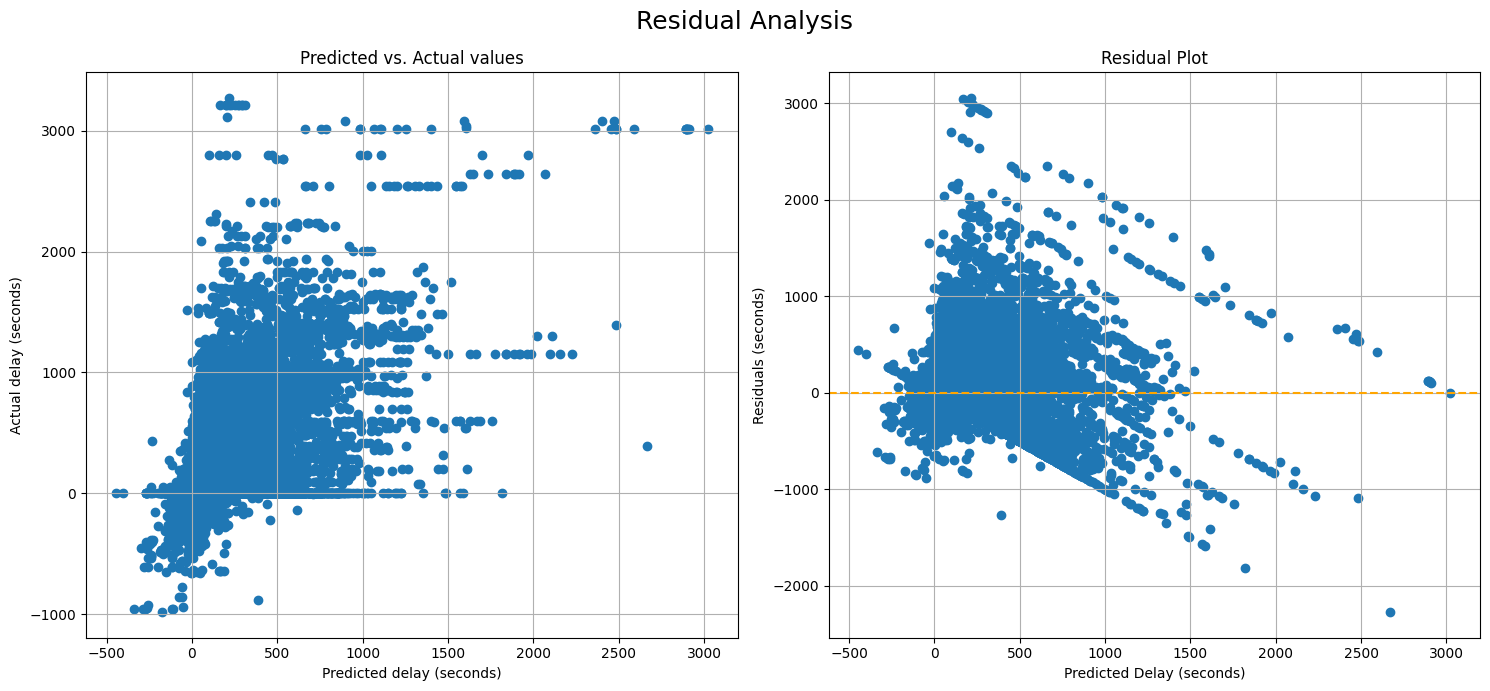

In [29]:
# Plot residuals
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Predicted vs. actual values
ax1.scatter(x=y_pred, y=y_val)
ax1.set_title('Predicted vs. Actual values')
ax1.set_xlabel('Predicted delay (seconds)')
ax1.set_ylabel('Actual delay (seconds)')
ax1.grid(True)

# Residuals
residuals = y_val - y_pred
ax2.scatter(x=y_pred, y=residuals)
ax2.set_title('Residual Plot')
ax2.set_xlabel('Predicted Delay (seconds)')
ax2.set_ylabel('Residuals (seconds)')
ax2.axhline(0, linestyle='--', color='orange')
ax2.grid(True)

fig.suptitle('Residual Analysis', fontsize=18)
fig.tight_layout()
fig.savefig(f'../images/residual_analysis.png', bbox_inches='tight')
plt.show()

**Predicted vs. Actual Plot**

There's a dense cluster around 0 for both predicted and actual values, indicating many predictions and centered near 0. However, there is substantial spread both above and below the diagonal line, which suggests underprediction and overprediction. There are clear outliers that are far from the main cluster.


**Residual Plot**

The residuals show a visible diagonal stripe pattern, which indicates a systematic error in prediction. The spread of residuals increases as the predicted delay increases. This is a sign of heteroscedasticity (the variance of errors is not constant across all predictions).

## Feature Importance Plot

In [31]:
feature_importances = best_model.get_feature_importance(prettified=True)
feature_importances = feature_importances.sort_values(by='Importances', ascending=False)
feature_importances

,Feature Id,Importances
0,exp_trip_duration,25.520963
1,hist_avg_delay,13.937460
2,stop_location_group,10.790936
3,relative_humidity,4.917058
4,temperature,4.800610
5,wind_gusts,4.672642
6,wind_direction,4.634667
7,route_type_HighFrequency,4.631505
8,route_direction_West,4.449193
9,windspeed,4.408526


## SHAP Plots

## Feature Pruning

## Retrain Model with Best Features

## Retune Parameters

## Final Model

### Evaluate with Test Set

### Make Prediction

In [ ]:
# Save best model
joblib.dump(best_model, 'best_xgb_model.pkl')

## End